[[0.46469871 1.11848353]]
[[0.42208244 1.24392885]]


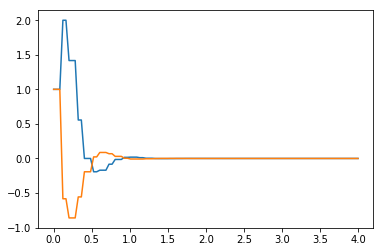

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from pydrake.all import (DirectTranscription, LinearSystem, LinearQuadraticRegulator, 
                         PiecewisePolynomial, SolutionResult)
A = np.array([[1, 1], [0, 1]])
B = np.array([[0], [1]])
Q = np.identity(2)
R = np.identity(1)

sys = LinearSystem(A,B,np.identity(2),np.zeros((2,1)),0.1)
context = sys.CreateDefaultContext()
kNumTimeSteps = 41  # Note: When this was 21, it converged on a local minima.

prog = DirectTranscription(sys, context, kNumTimeSteps)
K = prog.NewContinuousVariables(1, 2, 'K')
prog.AddConstraintToAllKnotPoints(prog.input()[0] == (-K.dot(prog.state()))[0])
prog.AddRunningCost(prog.state().dot(Q.dot(prog.state())) + prog.input().dot(R.dot(prog.input())))
prog.AddBoundingBoxConstraint([1., 1.], [1., 1.], prog.initial_state())


############################################################
# My Custom Autodiff Functions
############################################################
from NNSystemHelper import FC, MLP, NNInferenceHelper
# net = FC().double()
net = MLP().double()
def autodiffable_function_simple(x):
    return (x[0]-2.)*(x[1]-2.)
def autodiffable_function_nn(drake_in):
    global net
    in_list = list(drake_in)
    out_list = NNInferenceHelper(net, in_list)
    return out_list[0]

############################################################
# Single AddCost()
############################################################
# prog.AddCost(autodiffable_function_simple, K.T)
# prog.AddCost(autodiffable_function_nn, K.T)

############################################################
# AddRunningCost()
############################################################
def autodiffable_function_nn_real(state_concat_inp):
    # Unpack variables
    x_sz = len(prog.state(0))
    u_sz = len(prog.input(0))
    assert len(state_concat_inp) == x_sz + u_sz
    x = state_concat_inp[:x_sz]
    u = state_concat_inp[-u_sz:]
    
    # Should we use an NN? or not.
    ad_fn = autodiffable_function_simple
#     ad_fn = autodiffable_function_nn
    
    lam, rho = 1, 1 # For now, set the dual variables to constants
    cost = lam * (ad_fn(x) - u) \
        + rho * (ad_fn(x) - u).dot(ad_fn(x) - u)
    return cost[0]

# prog.AddCost(autodiffable_function_nn_real, np.hstack((prog.state(0), prog.input(0)))) # For debugging
# Looking to add cost of form 𝜆_𝑡(𝜋_𝜃(𝑥_𝑡) − 𝑢_𝑡) + 𝜌_𝑡(𝜋_𝜃(𝑥_𝑡) − 𝑢_𝑡)^2
for t in range(kNumTimeSteps):
    prog.AddCost(autodiffable_function_nn_real, np.hstack((prog.state(t), prog.input(t))))
    pass
############################################################

ret = prog.Solve()
print(prog.GetSolution(K))

x_trajectory = prog.ReconstructStateTrajectory()
breaks = np.linspace(x_trajectory.start_time(),x_trajectory.end_time(),100)
x_knots = np.hstack([x_trajectory.value(t) for t in breaks])

K_expected = -LinearQuadraticRegulator(sys, Q, R).D()
print(K_expected)

plt.plot(breaks, x_knots[0,:], breaks, x_knots[1,:])